# Programming Exercise 7: K-means Clustering and Principal Component Analysis

> In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. In the second part, you will use principal component analysis to find a low-dimensional representation of face images.

## 1. K-means Clustering
> In this this exercise, you will implement the K-means algorithm and use it
for image compression.

### 1.1 Implementing K-means

> The K-means algorithm is a method to automatically cluster similar data examples together. The intuition behind K-means is an iterative procedure that starts by guess- ing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

#### 1.1.1 Finding Closest Centroids

For every example $i$ we set $c_{(i)} := j$ that minimizes $||x^{(i)}-\mu_j||^2$ where $c_{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the j'th centroid.

In [2]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Define a function to find the closest centroid for each example in X
def find_closest_centroid(X, centroids):
    # Initialize an array to store the index of the closest centroid for each example
    idx = np.zeros((X.shape[0], 1))
    
    # Loop through each example in X
    for i in range(X.shape[0]):
        # Calculate the Euclidean distance between the current example and all centroids
        distances = np.sqrt(np.sum((X[i, :] - centroids) ** 2, axis=1))
        
        # Find the index of the centroid with the minimum distance and assign it to the corresponding example
        idx[i] = np.argmin(distances) + 1  # Adding 1 to match the centroid indices starting from 1
        
    return idx


In [4]:
mat = scipy.io.loadmat('data/ex7data2.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [5]:
K = 3
initial_centroids = np.array([[3,3],[6,2],[8,5]])
idx = find_closest_centroid(mat['X'], initial_centroids)
print('Closest centroids for the first 3 examples:', idx[:3].T)
print('(the closest centroids should be 1, 3, 2 respectively)')

Closest centroids for the first 3 examples: [[1. 3. 2.]]
(the closest centroids should be 1, 3, 2 respectively)


#### 1.1.2 Computing Centroid Means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid k we set $\mu_k := \frac{1}{|C_k|}\sum_{i \in C_k}x^{(i)}$

In [6]:
# Define a function to compute the centroids for each cluster
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    # Loop through each centroid
    for i in range(K):
        # Find all examples assigned to the current centroid
        assigned_examples = X[(idx == i+1).ravel(), :]
        # Compute the mean of the assigned examples to get the new centroid
        centroids[i, :] = np.mean(assigned_examples, axis=0)
    return centroids


In [7]:
# Compute centroids after initial finding of closest centroids
centroids = compute_centroids(mat['X'], idx, K)
print('Centroids computed after initial finding of closest centroids: \n', centroids)
print('\n(the centroids should be\n [ 2.428301 3.157924 ]\n[ 5.813503 2.633656 ]\n[ 7.119387 3.616684 ]')


Centroids computed after initial finding of closest centroids: 
 [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

(the centroids should be
 [ 2.428301 3.157924 ]
[ 5.813503 2.633656 ]
[ 7.119387 3.616684 ]


### 1.2 K-means on example dataset

In [8]:
# This function plots the data points and centroids during the K-means algorithm iterations.
# Parameters:
# - X: The dataset matrix.
# - centroids: The current centroids.
# - previous: The previous centroids.
# - idx: The index of the closest centroid for each data point.
# - K: The number of centroids.
# - axes: The axes to plot the data.

def plot_kmeans(X, centroids, previous, idx, K, axes):
    # Loop through each subplot
    for i, ax in enumerate(axes):
        # Plot data points colored by their cluster
        sns.scatterplot(x=X[:,0], y=X[:,1], hue=idx.ravel(), legend=False, palette=['r', 'g', 'b'], ax=ax)
        
        # Plot current centroids
        if i == 0:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        else:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        
        # Plot lines connecting current and previous centroids
        for i in range(centroids.shape[0]):
            ax.plot([centroids[i,0], previous[i,0]], [centroids[i,1], previous[i,1]], '--k');   


In [9]:
# This function performs the K-means algorithm on the dataset.
# Parameters:
# - X: The dataset matrix.
# - initial_centroids: The initial centroids.
# - max_iters: The maximum number of iterations.
# - plot_progress: Whether to plot the progress of K-means.

def kmeans(X, initial_centroids, max_iters, plot_progress):
    # Plot progress setup
    if plot_progress:
        ncols = 3
        nrows = int(max_iters/ncols)
        if max_iters % ncols > 0:
            nrows = nrows + 1
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,nrows*8))
        ax_tuple = list(np.ndindex(nrows, ncols))
        for ax in ax_tuple[max_iters:]:
            axes[ax].set_axis_off()
        ax_tuple = ax_tuple[:max_iters]
        
    # Initialize variables
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids

    # Iterate through max_iters
    for i in range(max_iters):
        idx = find_closest_centroid(X, centroids)
        
        # Plot progress if enabled
        if plot_progress:
            plot_axes = [axes[axi] for axi in ax_tuple[i:]]
            axes[ax_tuple[i]].set_title('K-Means iteration {0}/{1}'.format(i+1, max_iters))
            plot_kmeans(X, centroids, previous_centroids, idx, K, plot_axes)
            previous_centroids = centroids
            previous_ax = plt.gca()
        else:
            print('K-Means iteration {0}/{1}'.format(i+1, max_iters))
        
        centroids = compute_centroids(X, idx, K)
    
    # Show plot if progress was plotted
    if plot_progress:
        plt.show()
    
    return centroids, idx


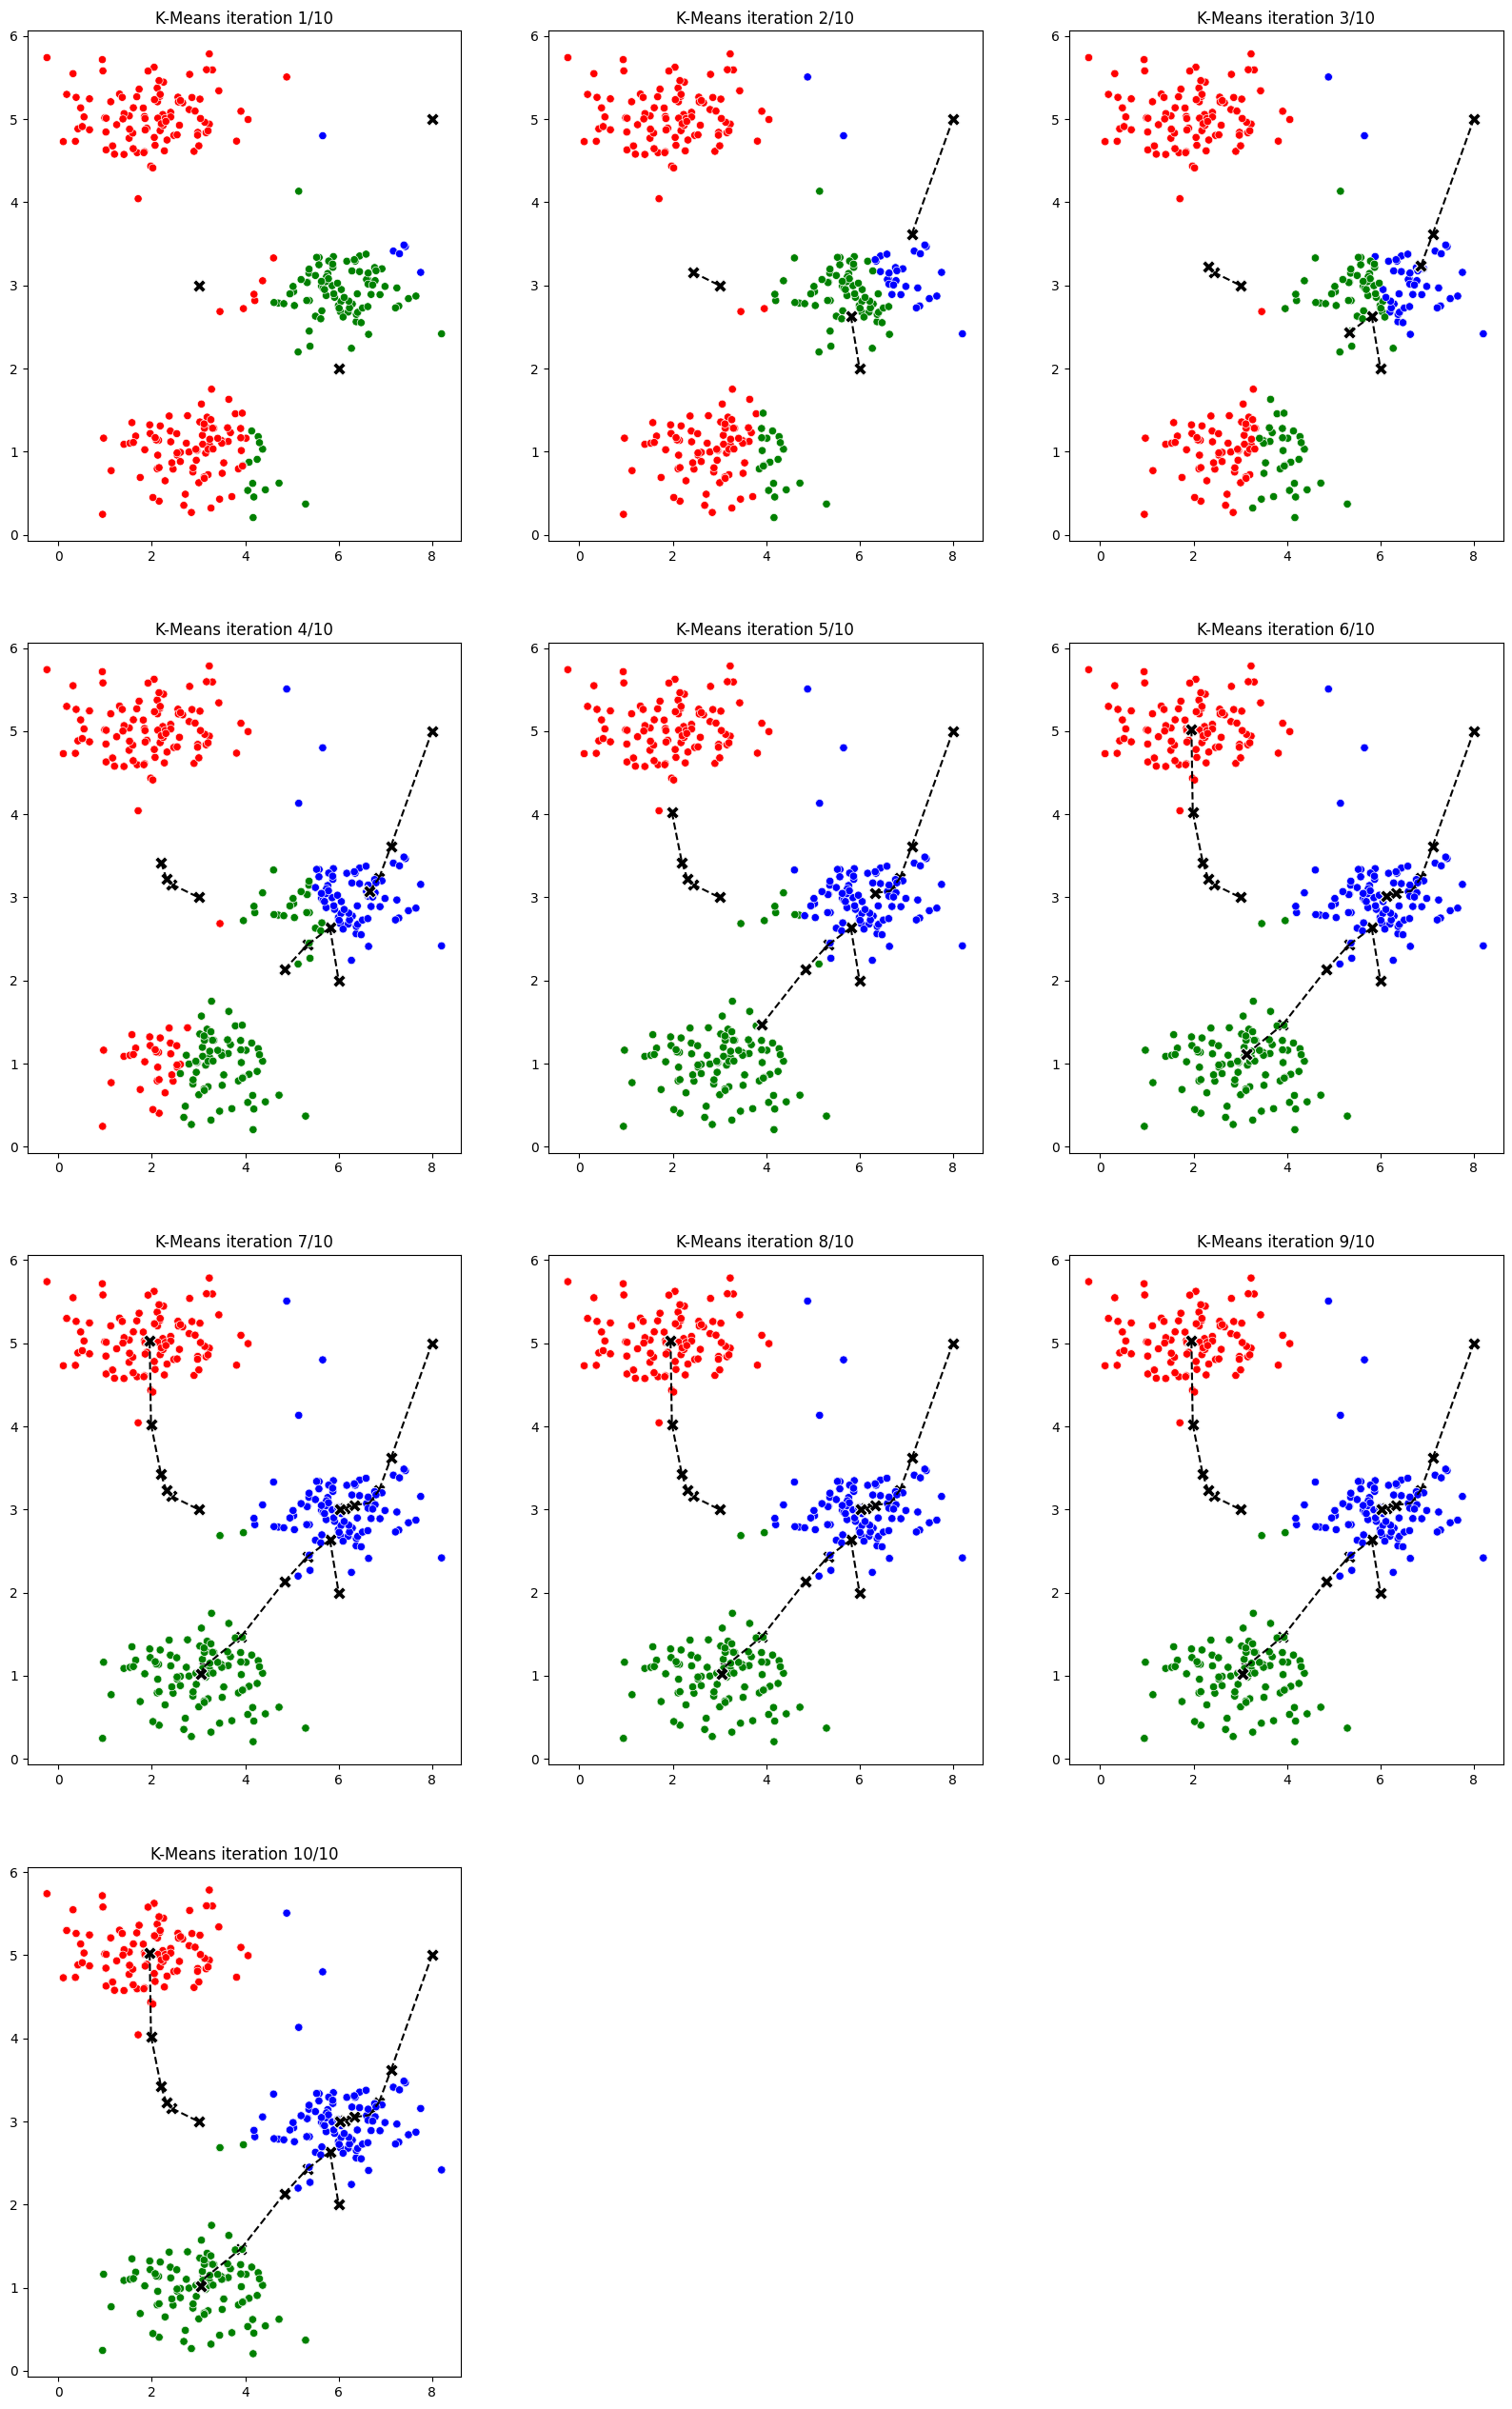

In [10]:
# Define the number of clusters (K), the maximum number of iterations, and the initial centroids.
K = 3
max_iters = 10
initial_centroids = np.array([[3,3],[6,2],[8,5]])

# Perform K-means clustering on the dataset with the specified parameters and plot the progress.
centroids, idx = kmeans(mat['X'], initial_centroids, max_iters, True)


### 1.3 Random initialization

In [11]:
def init_random_centroids(X, K):
    centroids = X[(np.random.choice(X.shape[0], K)), :]
    return centroids

#### Equivalent Code using Scikit-Learn

In [12]:
from sklearn.cluster import KMeans
initial_centroids = np.array([[3,3],[6,2],[8,5]])
kmeans_model = KMeans(n_clusters=K, max_iter=max_iters, init=initial_centroids).fit(mat['X'])

/home/muhammad/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/muhammad/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


Comparing the final centroids:

In [13]:
kmeans_model.cluster_centers_ 

array([[1.95399466, 5.02557006],
       [3.04367119, 1.01541041],
       [6.03366736, 3.00052511]])

In [14]:
centroids

array([[1.95399466, 5.02557006],
       [3.04367119, 1.01541041],
       [6.03366736, 3.00052511]])

Comparing labels of each point:

In [15]:
(kmeans_model.labels_.all()) == (idx.T[0].astype(int)-1).all()

True

### 1.4 Image Compression with K-means

> In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

#### 1.4.1 K-means on pixels

##### Load image

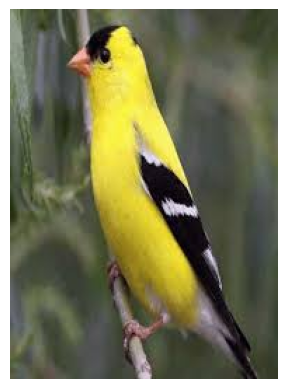

In [17]:
import cv2
img = cv2.imread('data/bird.jpeg')
plt.axis('off');
plt.imshow(img[:,:,::-1]);

In [18]:
A = img[:,:,::-1]
A = np.divide(img, 255) #get all values in range 0-1

In [19]:
A.shape

(264, 191, 3)

In [20]:
A = A.reshape((A.shape[0]*A.shape[1], 3))

In [21]:
A.shape

(50424, 3)

##### Run K-Means

In [22]:
K = 16
max_iters = 10
initial_centroids = init_random_centroids(A, K)
centroids, idx = kmeans(A, initial_centroids, max_iters, False)

K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


##### Apply K-Means to compress an image

In [23]:
idx = find_closest_centroid(A, centroids)
idx = idx.astype(int)

In [24]:
idx.shape

(50424, 1)

In [25]:
X_recovered = np.zeros((idx.shape[0], 3))
for i in range(idx.shape[0]):
    X_recovered[i,:] = centroids[idx[i]-1,:]

In [26]:
X_recovered = X_recovered.reshape((img.shape[0], img.shape[1], 3))

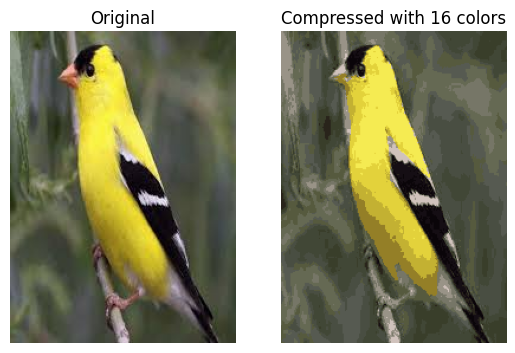

In [27]:
plt.subplot(1,2,1)
plt.axis('off');
plt.title('Original')
plt.imshow(img[:,:,::-1]);

plt.subplot(1,2,2)
plt.axis('off');
plt.title('Compressed with 16 colors')
plt.imshow(X_recovered[:,:,::-1]);

In [32]:
# Define the values of K (number of clusters) and the maximum number of iterations.
K_vals = [2, 8, 16, 24, 36]
max_iters = 10

# Initialize a list to store the compressed images.
imgs_compressed = []

# Iterate over each value of K.
for ik, K in enumerate(K_vals):
    print('\nRunning K-Means with K={}'.format(K))
    
    # Initialize random centroids.
    initial_centroids = init_random_centroids(A, K)
    
    # Perform K-means clustering without plotting the progress.
    centroids, idx = kmeans(A, initial_centroids, max_iters, False)
    
    # Perform image compression.
    idx = find_closest_centroid(A, centroids)
    idx = idx.astype(int)
    
    # Recover the compressed image.
    X_recovered = np.zeros((idx.shape[0], 3))
    for i in range(idx.shape[0]):
        X_recovered[i, :] = centroids[idx[i] - 1, :]
    X_recovered = X_recovered.reshape((img.shape[0], img.shape[1], 3))
    
    # Append the compressed image to the list.
    imgs_compressed.append(X_recovered)



Running K-Means with K=2
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=8
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=16
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=24
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration

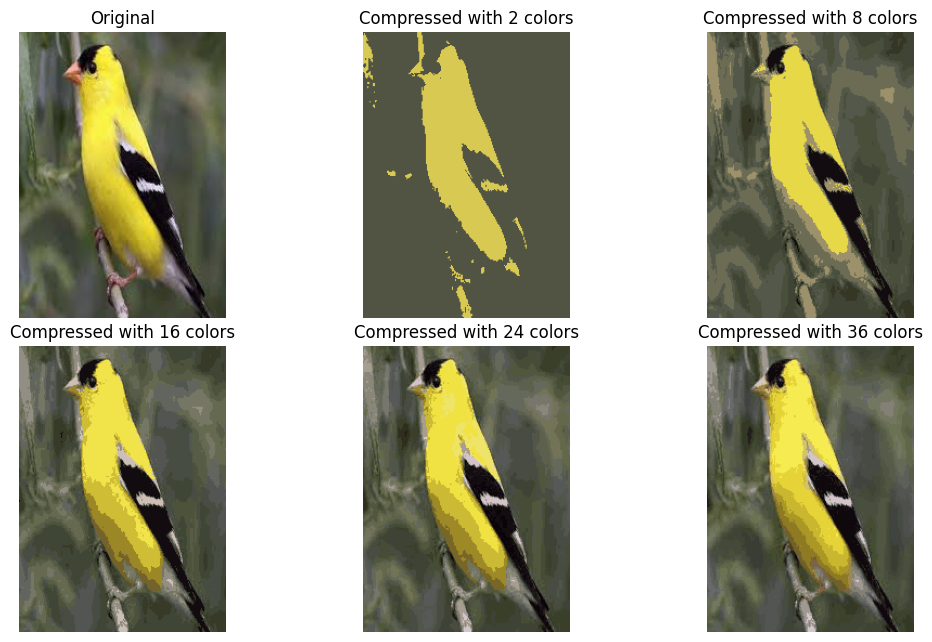

In [33]:
# Create a figure for plotting the original and compressed images.
fig = plt.figure(figsize=(10, 6))

# Define the number of rows and columns for the subplots.
rows = 2
cols = 3

# Plot the original image in the first subplot.
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img[:, :, ::-1])  # Show the original image (RGB channels are reversed).
ax1.set_axis_off()  # Turn off the axis.
ax1.set_title('Original')  # Set the title for the subplot.

# Plot the compressed images for each value of K in subsequent subplots.
for i in range(len(imgs_compressed)):
    ax1 = fig.add_subplot(rows, cols, i + 2)  # Increment the subplot index.
    ax1.imshow(imgs_compressed[i][:, :, ::-1])  # Show the compressed image.
    ax1.set_axis_off()  # Turn off the axis.
    ax1.set_title('Compressed with {} colors'.format(K_vals[i]))  # Set the title for the subplot.

# Adjust the spacing between subplots and display the figure.
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()


## 2. Principal Component Analysis

> In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

### 2.1 Example Dataset

<Axes: >

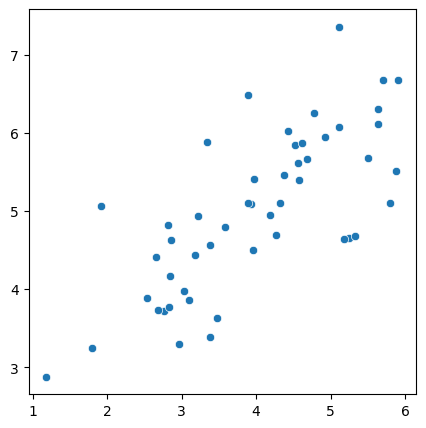

In [34]:
# Load the data from the provided .mat file.
mat = scipy.io.loadmat('data/ex7data1.mat')

# Create a scatter plot of the data points.
plt.figure(figsize=(5, 5))  # Set the figure size.
sns.scatterplot(x=mat['X'][:, 0], y=mat['X'][:, 1])  # Plot X coordinates against Y coordinates.


### 2.2 Implementing PCA

PCA consists of two computational steps: First, you compute the covariance matrix of the data. Then, you use SVD function to compute the eigenvectors $U1, U2, ... , Un$. These will correspond to the principal components of variation in the data.

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

In [35]:
# Define a function to normalize the features of the input data.
def feature_normalize(X):
    # Compute the mean of each feature.
    mean = np.mean(X, axis=0)
    # Subtract the mean from each feature.
    X_norm = np.subtract(X, mean)
    
    # Compute the standard deviation of each feature, with a correction for degrees of freedom.
    std = np.std(X_norm, axis=0, ddof=1)
    # Divide each feature by its standard deviation to normalize the data.
    X_norm = X_norm / std
    
    return X_norm, mean, std


Covariance matrix: $\Sigma = \frac{1}{m}X^TX$
<br>
SVD computes the principal components.

In [36]:
# Define a function to perform principal component analysis (PCA) on the input data.
def pca(X):
    # Get the number of examples in the dataset.
    m = X.shape[0]
    # Compute the covariance matrix of the input data.
    covariance_matrix = (1/m) * (X.T.dot(X))
    # Perform singular value decomposition (SVD) on the covariance matrix to get the principal components.
    U, S, _ = np.linalg.svd(covariance_matrix)
    return U, S


In [37]:
X_norm, mu, sigma = feature_normalize(mat['X'])

In [38]:
U, S = pca(X_norm)

Text(0.5, 1.0, 'Computed eigenvectors of the dataset')

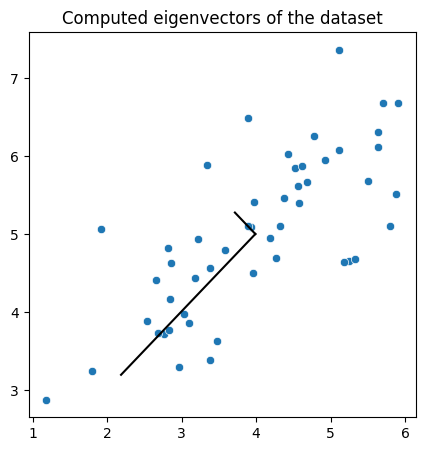

In [39]:
# Visualize the dataset along with the computed eigenvectors.
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x=mat['X'][:,0], y=mat['X'][:,1])

# Plot the first eigenvector scaled by 1.5 standard deviations.
p1 = mu
p2 = mu + 1.5 * S[0] * U[:,0].T
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k')

# Plot the second eigenvector scaled by 1.5 standard deviations.
p1 = mu
p2 = mu + 1.5 * S[1] * U[:,1].T
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k')

plt.title('Computed eigenvectors of the dataset')


In [40]:
print('Top eigenvector:')
print(' U(:,1) = ', U[0,0], U[1,0])
print('(you should expect to see -0.707107 -0.707107)')

Top eigenvector:
 U(:,1) =  -0.7071067811865472 -0.7071067811865475
(you should expect to see -0.707107 -0.707107)


### 2.3 Dimensionality Reduction with PCA

#### 2.3.1 Projecting the data onto the principal components

In [41]:
# Project the data onto the first K eigenvectors in U.
def project_data(X, U, K):
    Z = np.zeros((X.shape[0], K))
    for i in range(X.shape[0]):
        x = X[i,:].T
        for j in range(K):
            Z[i,j] = x.T.dot(U[:,j])
    return Z


In [42]:
K=1
Z = project_data(X_norm, U, K)
print('Projection of the first example:', Z[0])
print('(this value should be about 1.481274)')

Projection of the first example: [1.48127391]
(this value should be about 1.481274)


#### 2.3.2 Reconstructing an approximation of the data

In [43]:
# Recover an approximation of the original data from the projected data.
def recover_data(Z, U, K):
    X_rec = np.zeros((Z.shape[0], U.shape[0]))
    for i in range(Z.shape[0]):
        z = Z[i,:].T
        for j in range(U.shape[0]):
            X_rec[i,j] = z.T.dot(U[j,:K])
    return X_rec


In [44]:
X_rec = recover_data(Z, U, K)
print('Approximation of the first example:', X_rec[0, 0], X_rec[0, 1])
print('(this value should be about  -1.047419 -1.047419)')

Approximation of the first example: -1.0474188259204957 -1.047418825920496
(this value should be about  -1.047419 -1.047419)


#### 2.3.3 Visualizing the projections

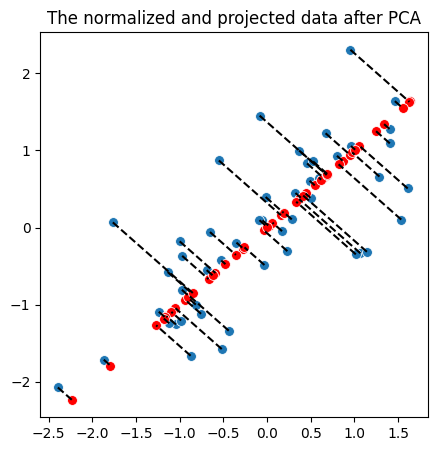

In [45]:
# Plot the normalized and projected data after PCA.
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x=X_norm[:,0], y=X_norm[:,1], s=50)
ax = sns.scatterplot(x=X_rec[:,0], y=X_rec[:,1], color='r', s=50)
for i in range(X_norm.shape[0]):
    p1 = X_norm[i,:]
    p2 = X_rec[i,:]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], '--k')
plt.title('The normalized and projected data after PCA');


### 2.4 Face Image Dataset

In [46]:
mat = scipy.io.loadmat('data/ex7faces.mat')

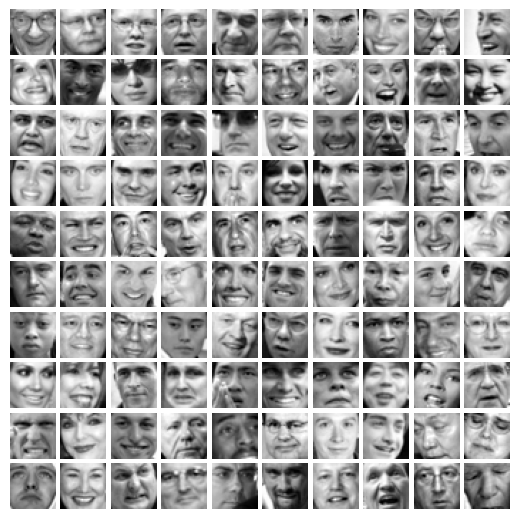

In [47]:
# Display a grid of images from the dataset.
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
count = 0
for i in range(0,rows):
    for j in range(0,cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(mat['X'][count].reshape(32,32).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()


#### 2.4.1 PCA on Faces

In [48]:
X_norm, mu, sigma = feature_normalize(mat['X'])

In [49]:
U, S = pca(X_norm)

In [50]:
U.shape

(1024, 1024)

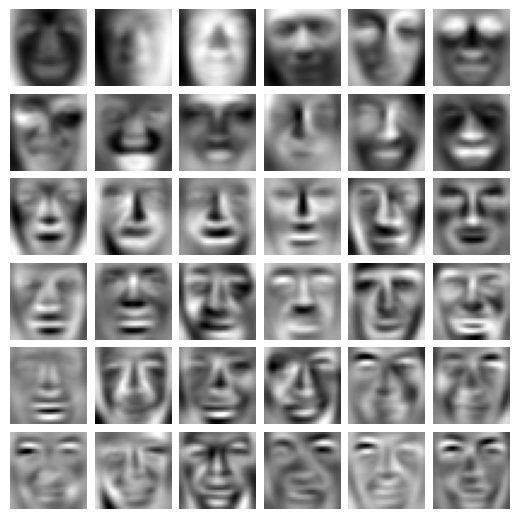

In [51]:
# Display a grid of the first 36 principal components.
rows = 6
cols = 6
fig = plt.figure(figsize=(5,5))
count = 0
for i in range(rows):
    for j in range(cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(U[:, count].T.reshape(32,32).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()


#### 2.4.2 Dimensionality Reduction

In [52]:
K=100
Z = project_data(X_norm, U, K)

In [53]:
print('The projected data Z has a size of: ', Z.shape)

The projected data Z has a size of:  (5000, 100)


Visualizing the reduced dimension faces

In [54]:
X_rec  = recover_data(Z, U, K)

Original:

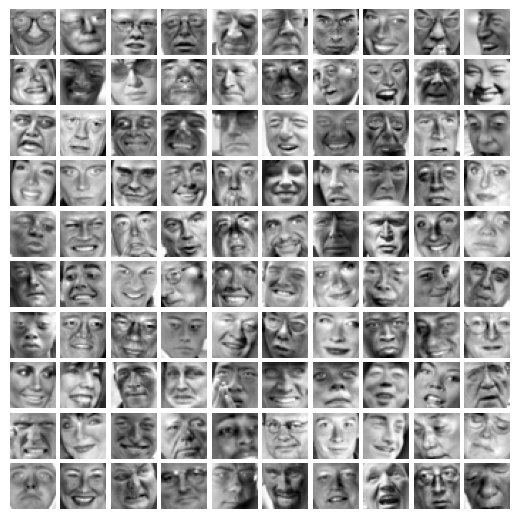

In [55]:
# Display a grid of the first 100 normalized images.
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
count = 0
for i in range(rows):
    for j in range(cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(X_norm[count].reshape(32,32).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()


Reconstructed

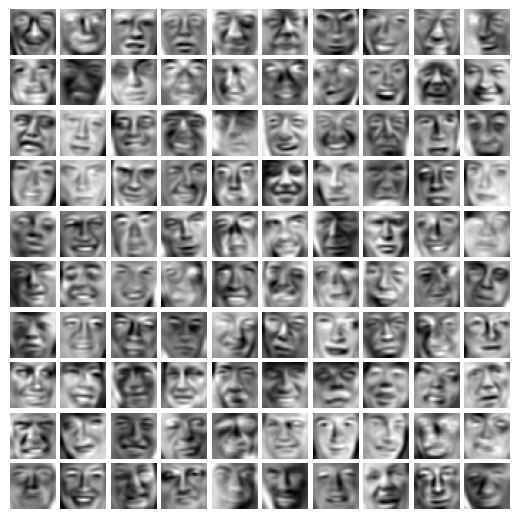

In [56]:
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
count = 0
for i in range(rows):
    for j in range(cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(X_rec[count].reshape(32,32).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

### 2.5 PCA for visualization

In [57]:
# Load the image and preprocess it.
img = cv2.imread('data/bird_small.png')

# Reverse the color channels to RGB.
A = img[:,:,::-1]

# Normalize the pixel values to range [0, 1].
A = np.divide(img, 255)

# Reshape the image data to a matrix where each row represents a pixel and its RGB values.
A = A.reshape((A.shape[0]*A.shape[1], 3), order='F')

# Set the number of clusters (K) and the maximum number of iterations for K-means.
K = 16
max_iters = 10

# Initialize random centroids and perform K-means clustering.
initial_centroids = init_random_centroids(A, K)
centroids, idx = kmeans(A, initial_centroids, max_iters, False)


K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


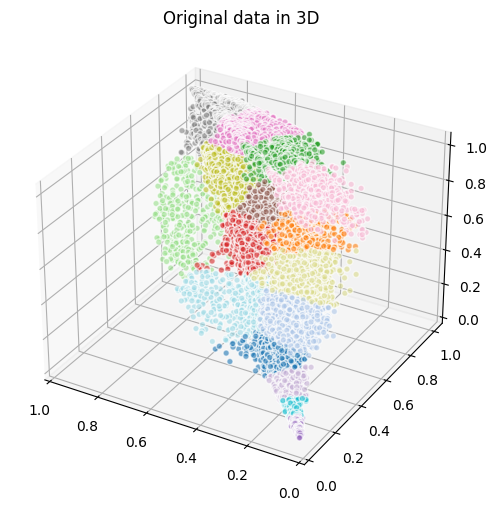

In [58]:
# Import necessary libraries for plotting.
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and a 3D subplot.
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points colored by their assigned cluster index.
ax.scatter3D(A[:,0], A[:,1], A[:,2], alpha=0.6, edgecolors='w', c=idx.ravel(), cmap=plt.get_cmap("tab20"))

# Set the limits of the x-axis to reverse it for better visualization.
ax.set_xlim(1, 0)

# Set the title of the plot.
plt.title('Original data in 3D')

# Display the plot.
plt.show()


In [59]:
# Normalize the features of the data.
X_norm, mu, sigma = feature_normalize(A)

# Perform principal component analysis (PCA) to reduce the dimensionality to 2.
U, S = pca(X_norm)

# Project the normalized data onto the first two principal components.
Z = project_data(X_norm, U, 2)


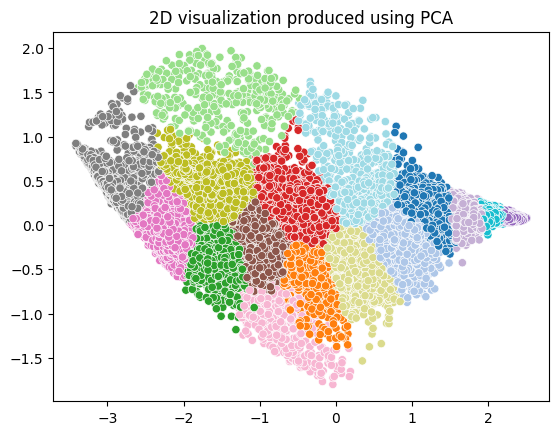

In [60]:
# Visualize the 2D projection of the data points after PCA.
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=idx.ravel(), legend=False, palette=plt.get_cmap("tab20"))
plt.title('2D visualization produced using PCA');
